# **Projeto XAI: Interpretabilidade de modelos**

---

## Tema: **Predição de falhas e eventos de manutenção em máquinas industriais**

---
## **Roteiro**
---
### -  Pacotes
### 1. Dataset Escolhido
    - 1.1 Dataset: AI4I 2020 Predictive Maintenance Dataset
    - 1.2 Descrição Geral
    - 1.3 Estrutura do Dataset
    - 1.4 Contexto
    - 1.5 Carregando o Dataset

### 2. Exploração dos dados
    - 2.1 Informações do Dataset
    - 2.2 Matriz de Correlação
    - 2.3 Escolha do Target
    - 2.4 Estratégias para desbalanceamento das classes

### 3. Pré-processamento dos dados
    - 3.1 Convertendo variável categórica em numérica
    - 3.2 Normalização dos dados
### 4. Treinamento e Avaliação de Algoritmos
    - 4.1 Separação dos dados em treinamento e teste
    - 4.2 StratifiedKfold
    - 4.3 Modelos para treinamento
    - 4.4 RandomizedSearchCV
    - 4.5 Random Forest
    - 4.6 Logistic Regression
    - 4.7 Support Vector Machine
    - 4.8 Decision Trees

### 5. Global Surrogates
    - 5.1 Modelo caixa-preta e modelo caixa-branca 1
    - 5.2 Modelo caixa-preta e modelo caixa-branca 2
    - 5.3 Análise R-squared para os dois modelos Surrogates

### 6. Permutation Feature Importance (PFI)
    - 6.1 Modelo Random Forest
    - 6.2 PFI Classe minoritária (Falhou)
    - 6.3 Classe Majoritária (Não falhou)

### 7. Feature Selection
    - 7.1 Análise dos resultados

### 8. LIME
    - 8.1 Definindo modelo para o Lime
    - 8.2 Criando um explicador utilizando LIME nos dados de treinamento
    - 8.3 Selecionando Instância 1
    - 8.4 Selecionando Instância 2
    - 8.5 Selecionando Instância 3
    - 8.6 Selecionando Instância 4

### 9. Partial Dependence Plots
    - 9.1 Análise PDPs obtidos

### Pacotes

In [ ]:
! pip install ucimlrepo

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=31c2976698e8e9fc30fefe7ae66716ca53da6f83956e1f8b3f235f1e6f6d9349
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import uniform
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import lime
import lime.lime_tabular

### **1. Dataset Escolhido**

### 1.1. Dataset: AI4I 2020 Predictive Maintenance Dataset

O AI4I 2020 Predictive Maintenance Dataset está disponível no UCI Machine Learning Repository e foi desenvolvido para simular problemas de manutenção preditiva em processos industriais.

Link do dataset: https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset


### 1.2 Descrição Geral

Este dataset é destinado à predição de falhas e eventos de manutenção em máquinas industriais, focando em identificar padrões que indiquem necessidade de manutenção antes que falhas ocorram.


### 1.3 Estrutura do Dataset

| **Variável**                | **Tipo**           | **Descrição**                                              |
|-----------------------------|--------------------|------------------------------------------------------------|
|                   |
| |
| **Type**                    | Categórica         | Tipo de produto: `L`, `M`, `H` (baixo, médio e alto valor)  |
| **Air temperature [K]**      | Contínua (Numérica)| Temperatura do ar medida em Kelvin                         |
| **Process temperature [K]**  | Contínua (Numérica)| Temperatura do processo medida em Kelvin                   |
| **Rotational speed [rpm]**   | Contínua (Numérica)| Velocidade de rotação da máquina (RPM)                     |
| **Torque [Nm]**              | Contínua (Numérica)| Torque da máquina em Newton-metros                         |
| **Tool wear [min]**          | Contínua (Numérica)| Tempo de uso da ferramenta em minutos                      |

| **Target**                  | **Tipo**           | **Descrição**                                              |
|-----------------------------|--------------------|------------------------------------------------------------|
| **Machine failure**          | Binária            | Falha geral da máquina (`0` = Não, `1` = Sim)              |
| **TWF (Tool Wear Failure)**  | Binária            | Falha devido ao desgaste da ferramenta                     |
| **HDF (Heat Dissipation Failure)** | Binária      | Falha devido à dissipação inadequada de calor              |
| **PWF (Power Failure)**      | Binária            | Falha devido à falta de energia                            |
| **OSF (Overstrain Failure)** | Binária            | Falha causada por sobrecarga                               |
| **RNF (Random Failures)**    | Binária            | Falha aleatória sem causa específica                       |


O dataset é composto por 6 variáveis, sendo 1 variável categórica e 5 variáveis contínuas numéricas. Como alvo, tem-se 6 possíveis variáveis de saída, todas binárias. Portanto, é um dataset que permite a realização de análises aprofundadas dependendo do que se deseja predizer, e assim identificar padrões de possíveis falhas em máquinas industriais que possam vir acontecer.

### 1.4 Contexto

O dataset é tipicamente adequado para experimentos de classificação binária, em que o objetivo pode ser prever se ocorrerá uma falha de máquina (Normalmente é este o alvo escolhido nos modelos de machine learning), ou falhas específicas (então outros alvos como *TWF*, *HDF*, *PWF* podem ser definidos para treinamento).

#### 1.4.1 Aplicações Potenciais

- Manutenção preditiva: Prever falhas em sistemas industriais com base nas condições de operação.

- Análise de confiabilidade: Examinar quais fatores mais contribuem para diferentes tipos de falhas.

- Explicabilidade: Ferramentas de XAI podem ser aplicadas para entender quais característcas são as mais importantes para a predição das falhas gerais ou específicas.

### 1.5 Carregando o Dataset

In [ ]:
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601)
X = ai4i_2020_predictive_maintenance_dataset.data.features
Y = ai4i_2020_predictive_maintenance_dataset.data.targets

### **2. Exploração dos dados**

In [ ]:
X.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool wear  
0          0  
1          3  
2          5  
3          7  
4          9

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 468.9+ KB


In [ ]:
X['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

A variável *Type* possui três possíveis valores:
- L (Low) - Baixo valor
- M (Medium) - Médio valor
- H (High) -  Alto valor

In [ ]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Machine failure  10000 non-null  int64
 1   TWF              10000 non-null  int64
 2   HDF              10000 non-null  int64
 3   PWF              10000 non-null  int64
 4   OSF              10000 non-null  int64
 5   RNF              10000 non-null  int64
dtypes: int64(6)
memory usage: 468.9 KB


### 2.1 Informações do Dataset

O dataset é composto por 10000 instâncias tanto nas variáveis explicativas quanto nas variáveis alvo, e sem valores nulos conforme contagem de *Non-Null Count*.

### 2.2 Matriz de Correlação

Uma matriz de correlação das variáveis explicativas numéricas com todos os alvos será apresentada a seguir. Entender como as variáveis explicativas se relacionam entre si e com as variáveis alvo é fundamental para identificar quais variáveis influenciam em falhas gerais e falhas específicas.

Momentaneamente, excluindo a variável categórica da análise.

In [ ]:
cat_cols = X.select_dtypes(include='object').columns.to_list()

In [ ]:
num_cols = X.columns.to_list()
for col in cat_cols:
  num_cols.remove(col)
num_cols

['Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear']

Concatenando num único dataframe variáveis explicativas numéricas e variáveis alvo.

In [ ]:
df = pd.concat([X[num_cols], Y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air temperature      10000 non-null  float64
 1   Process temperature  10000 non-null  float64
 2   Rotational speed     10000 non-null  int64  
 3   Torque               10000 non-null  float64
 4   Tool wear            10000 non-null  int64  
 5   Machine failure      10000 non-null  int64  
 6   TWF                  10000 non-null  int64  
 7   HDF                  10000 non-null  int64  
 8   PWF                  10000 non-null  int64  
 9   OSF                  10000 non-null  int64  
 10  RNF                  10000 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 859.5 KB


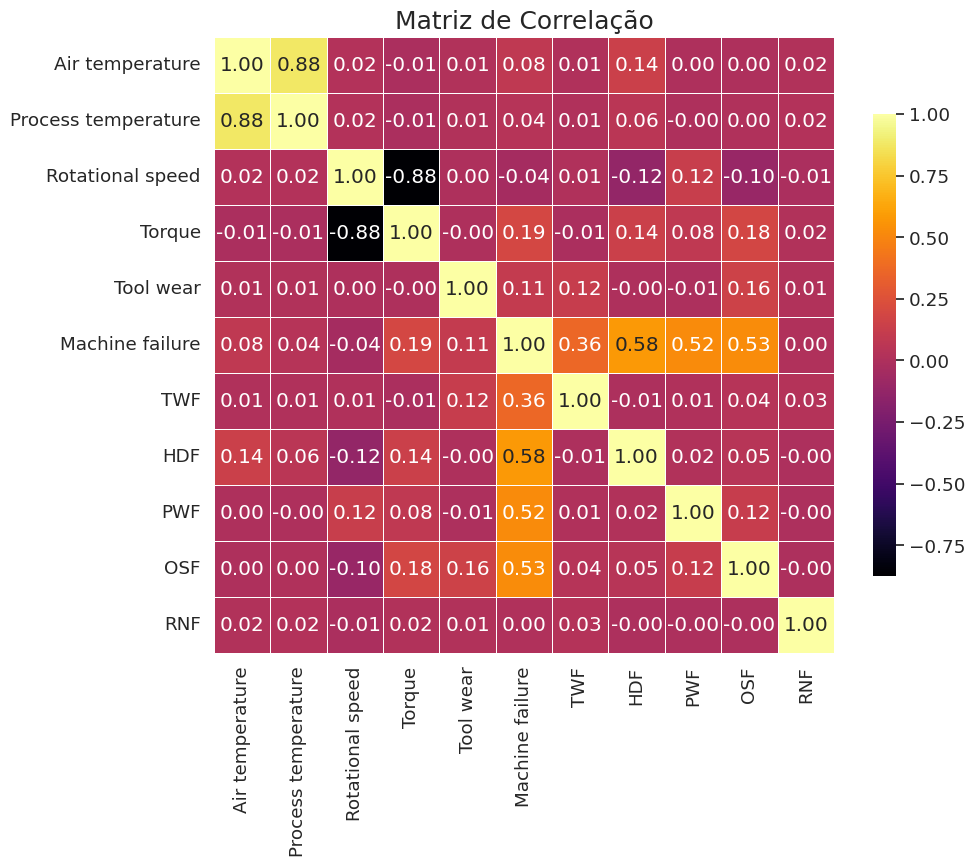

In [ ]:
corr_matrix = df.corr()
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='inferno', linewidths=0.5, fmt='0.2f', cbar_kws={"shrink": 0.75})
heatmap.set_title('Matriz de Correlação', fontsize=18)
plt.show()


### 2.2.1 Valores de referência para correlação
Alguns valores de referência serão adotados para interpretar as correlações entre as variáveis:

- Correlação forte: Valores acima de 0.5 (ou abaixo de -0.5) são geralmente considerados como indicação de uma forte correlação, seja positiva ou negativa.

- Correlação moderada: Entre 0.3 e 0.5 (ou entre -0.3 e -0.5) indica uma relação significativa, mas não tão forte.

- Correlação fraca ou desprezível: Abaixo de 0.3 (ou acima de -0.3) é considerada uma correlação fraca ou desprezível.

### 2.2.2 Análise das correlações:
- As variáveis *Air temperature* e *Process temperature* possuem uma alta correlação positiva de 0.88. São variáveis referentes a temperatura do ar e a temperatura do processo, portanto, muito importantes para os modelos que serão construídos, e não serão eliminadas apesar dos altos valores, pois a perda de informação ao excluí-las seria ainda maior.

- O mesmo se pode afirmar com relação as variáveis *Torque* e *Rotational speed*, que possuem forte correlação negativa de -0.88, variáveis referentes ao torque da máquina e velocidade de rotação da máquina, portanto, serão mantidas na construção dos modelos.
- As variáveis alvo *Machine failure* e *HDF* possuem uma correlação positiva de 0.58, já podendo ser considerado uma correlação forte. São referentes a falhas gerais e falhas por dissipação inadequada de calor.



### 2.3 Escolha do Target

Para análise, o alvo *Machine failure* foi o escolhido pois descreve falhas mecânicas gerais que acontecem em máquinas industriais, e entender quais variáveis influenciam nessas falhas é fundamental para impedir que venham acontecer.

In [ ]:
df_mf = pd.concat([X, Y['Machine failure']], axis=1)
df_mf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 10000 non-null  object 
 1   Air temperature      10000 non-null  float64
 2   Process temperature  10000 non-null  float64
 3   Rotational speed     10000 non-null  int64  
 4   Torque               10000 non-null  float64
 5   Tool wear            10000 non-null  int64  
 6   Machine failure      10000 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 547.0+ KB


In [ ]:
df_mf.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool wear  Machine failure  
0          0                0  
1          3                0  
2          5                0  
3          7                0  
4          9                0

Temos as 6 variáveis explicativas com o alvo definido como *Machine failure*.

### 2.3.1 Análise estatística das variáveis explicativas numéricas

In [ ]:
df_mf[num_cols].describe().T

count        mean         std     min     25%     50%  \
Air temperature      10000.0   300.00493    2.000259   295.3   298.3   300.1   
Process temperature  10000.0   310.00556    1.483734   305.7   308.8   310.1   
Rotational speed     10000.0  1538.77610  179.284096  1168.0  1423.0  1503.0   
Torque               10000.0    39.98691    9.968934     3.8    33.2    40.1   
Tool wear            10000.0   107.95100   63.654147     0.0    53.0   108.0   

                        75%     max  
Air temperature       301.5   304.5  
Process temperature   311.1   313.8  
Rotational speed     1612.0  2886.0  
Torque                 46.8    76.6  
Tool wear             162.0   253.0

- A análise estatística permite uma visualização tabular dos valores mínimos, máximos, médios, desvios padrões e ordem de grandeza das variáveis relacionadas com falhas gerais em máquinas industriais.
- Dos valores observados, percebe-se a necessidade de padronizar a escala dos dados para que variáveis como *Rotational speed* que possue um valor máximo de 2886 não influencie nas predições dos modelos.

### 2.3.2 Análise de balanceio de classes

In [ ]:
classes = list(df_mf['Machine failure'].value_counts())

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


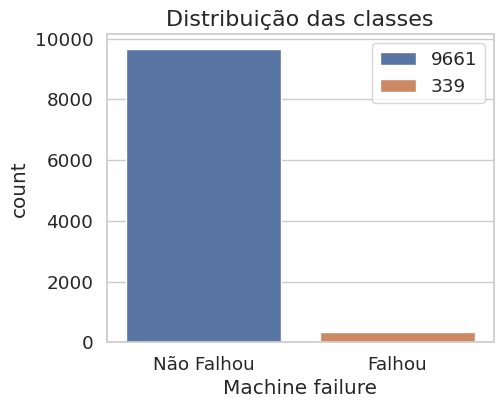

In [ ]:
fig = plt.figure(figsize=(5, 4))
label = {0: 'Não Falhou', 1: 'Falhou'}
sns.countplot(x='Machine failure', data=df_mf, hue='Machine failure')
plt.xticks(ticks=[0, 1], labels=[label[0], label[1]])
plt.title('Distribuição das classes', fontsize=16)
plt.legend(labels=[classes[0], classes[1]])
plt.show()


### 2.4 Estratégias para desbalanceamento das classes

Claramente há um grande desbalanceamento de classes, o que está alinhado com um cenário real, em que se espera poucas falhas em máquinas industriais. Porém, para treinamento e predição de modelos de machine learning, a classe minoritária (*Falhou*) pode acabar sendo tratada como ruído pelo classificador e a classe majoritária (*Não falhou*) dominar a predição. Algo que não se deseja que aconteça.

O artigo [*Effects of Class Imbalance Countermeasures on Interpretability*](https://ieeexplore.ieee.org/document/10478516) (2024) propõe algumas estratégias do que fazer ao se deparar com dataset desbalanceado, quais contramedidas são adequadas para que a interpretabilidade seja mantida, e quais comprometem a interpretabilidade. No contexto de interpretabilidade que se deseja manter, os autores citam a necessidade de *Compreensibilidade* para dois públicos:
- Usuários de IA: Compreender o processo do método ou as saídas ou predições (Por que?)
- Especialistas de IA: Entender e reproduzir a saída do método ou modelo (Como?)

Das estratégias típicas que normalmente são usadas com o propósito de melhorar o desempenho dos modelos e conseguir um balanceio de classes são:
- Resampling
- Ensemble methods

Os autores descrevem que as medidas acima são úteis e melhoram o desempenho dos modelos, porém ao mesmo tempo comprometem a interpretabilidade de como os resultados estão sendo obtidos.
- Resampling não é compreensível devido a amostragem aleatória dos dados, já Ensemble methods não são compreensíveis devido a própria natureza do método, com vários modelos ou envolvendo mecanismos de resampling.

### 2.4.1 Técnicas e métricas que serão usadas

Dentre as muitas técnicas e métricas para avaliação de desempenho dos modelos de machine learning, as seguintes serão usadas:

- Feature extraction: através de técnicas como Min-Max, StandardScaler com o objetivo de eliminar a influência de variáveis com escala de valores muito discrepantes em relação a outras variáveis, e assim, modelos como *regressão logística* e *SVM* que são sensíveis a escala não tenham seus desempenhos prejudicados. Apesar de que técnicas de normalização vem com uma perda de interpretabilidade, será aplicada com um trade-off, perdendo um pouco de entendimento e ganhando desempenho dos modelos.

- Feature selection: A eliminação de variáveis irrelevantes ajuda na interpretabilidade, e também no desempenho do modelo, pois o risco da classe minoritária ser tratada como ruído diminue, além de deixar o modelo mais simples.

- Stratified Cross-Validation: A realização da validação cruzada garante a preservação de proporção entre classes, pois a técnica *stratified cross-validation* está sendo aplicada.

- Randomized SearchCV: Em conjunto com a técnica de validação cruzada, a técnica *Randomized SearchCV* será aplicada. É uma técnica que explora combinações aleatórias de hiperparâmetros dentro de distribuições ou intervalos especificados, e assim garantir que os melhores hiperparâmetros de cada modelo foi selecionado para que o desempenho dos modelos melhorem.

- Métricas de avaliação de desempenho: F1-score, Precision-Recall AUC e MCC (Matthews Correlation Coeficient) são métricas mais adequadas no cenária de classes desbalanceadas.


### **3. Pré-processamento dos dados**

### 3.1 Convertendo variável categórica em numérica
A variável categórica *Type* será convertida em numérica com o método *LabelEncoder*.

In [ ]:
df_mf.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0    M            298.1                308.6              1551    42.8   
1    L            298.2                308.7              1408    46.3   
2    L            298.1                308.5              1498    49.4   
3    L            298.2                308.6              1433    39.5   
4    L            298.2                308.7              1408    40.0   

   Tool wear  Machine failure  
0          0                0  
1          3                0  
2          5                0  
3          7                0  
4          9                0

In [ ]:
df_mf['Type'] = LabelEncoder().fit_transform(df_mf['Type'])
df_mf.head()

Type  Air temperature  Process temperature  Rotational speed  Torque  \
0     2            298.1                308.6              1551    42.8   
1     1            298.2                308.7              1408    46.3   
2     1            298.1                308.5              1498    49.4   
3     1            298.2                308.6              1433    39.5   
4     1            298.2                308.7              1408    40.0   

   Tool wear  Machine failure  
0          0                0  
1          3                0  
2          5                0  
3          7                0  
4          9                0

As variáveis foram convertidas da seguinte forma:

- L = 0
- M = 1
- H = 2

### 3.2 Normalização dos dados

- O método *StandardScaler* será aplicado para normalização dos dados, para que algoritmos sensíveis a escala como SVM, Regressão logística não tenham seus desempenhos afetados.

- Além disso, por realizar uma transformação para os dados ter média 0 e desvio padrão 1, é menos sensível a outliers, sendo mais adequado para o contexto de manutenção preditiva do dataset.

### **4. Treinamento e Avaliação de Algoritmos**

Divisão do dataset em variáveis explicativas e variável alvo.

In [ ]:
X_mf = df_mf.drop('Machine failure', axis=1)
y_mf = df_mf['Machine failure']

### 4.1 Separação dos dados em treinamento e teste

O método train_test_split será usado tendo o cuidado de especificar o hiperparâmetro *stratify* com relação ao alvo, e assim mantendo a proporção das classes.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mf, y_mf, stratify=y_mf, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4.2 StratifiedKfold

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### 4.3 Modelos para treinamento

Os seguintes modelos serão treinados para treinamento e avaliação de desempenhos:
- Random Forest
- Logistic Regression
- Support Vector Machine
- Decision Trees

### 4.4 RandomizedSearchCV

A técnica RandomizedSearchCV será utilizada em todos os modelos.

### 4.5 Random Forest

In [ ]:
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': randint(50,200),
    'criterion':['gini', 'entropy'],
    'max_depth': randint(2,10),
    'min_samples_split': randint(2,10),
    'min_samples_leaf': randint(2,10),
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'random_state': [0, 13, 42],
}

rf_randomized = RandomizedSearchCV(rf,
                                   rf_params,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)

### 4.5.1 Treinando modelo de Random Forest

In [ ]:
rf_randomized.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a4322b60>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a05aa500>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a0772440>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a19d6740>,
                                        'n_jobs': [-1],
                                        'random_state': [0, 13, 42]},
                   scoring='f1')

### 4.5.2 Melhores hiperparâmetros e modelo

In [ ]:
best_params_rf = rf_randomized.best_params_
best_model_rf = rf_randomized.best_estimator_

print(f'Melhores hiperparâmetros: {best_params_rf}')
print(f'Melhor modelo: {best_model_rf}')

Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 79, 'n_jobs': -1, 'random_state': 42}
Melhor modelo: RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=3, min_samples_split=3, n_estimators=79,
                       n_jobs=-1, random_state=42)


In [ ]:
best_rf = RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=3, min_samples_split=3, n_estimators=79,
                       n_jobs=-1, random_state=42)

In [ ]:
best_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=3, min_samples_split=3, n_estimators=79,
                       n_jobs=-1, random_state=42)

### 4.5.3 Métricas de avaliação de desempenho

In [ ]:
y_pred_rf = best_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2415
           1       0.85      0.75      0.80        85

    accuracy                           0.99      2500
   macro avg       0.92      0.87      0.90      2500
weighted avg       0.99      0.99      0.99      2500



In [ ]:
mcc = matthews_corrcoef(y_test, y_pred_rf)
print(f'MCC: {mcc}')

MCC: 0.7950736533673157


In [ ]:
rf_predict_proba = best_rf.predict_proba(X_test_scaled)

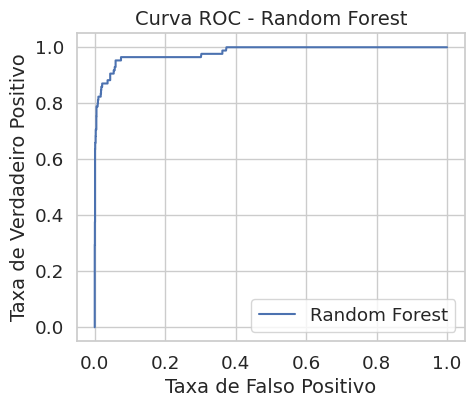

In [ ]:
fig = plt.figure(figsize=(5, 4))
fpr, tpr, thresholds = roc_curve(y_test, rf_predict_proba[:, 1])
plt.title('Curva ROC - Random Forest', fontsize=14)
plt.xlabel('Taxa de Falso Positivo', fontsize=14)
plt.ylabel('Taxa de Verdadeiro Positivo', fontsize=14)
plt.plot(fpr, tpr, label='Random Forest')
plt.legend()
plt.show()

In [ ]:
roc_auc_score(y_test, rf_predict_proba[:, 1])
print(f'AUC: {roc_auc_score(y_test, rf_predict_proba[:, 1])}')

AUC: 0.9807623919132871


Os resultados encontrados ao avaliar os dados de teste demonstram um desempenho bom do modelo de Random Forest, mesmo no cenário das classes desbalanceadas.

Como parâmetro de avaliação final da qualidade do modelo, considera-se a métrica Matthew's Correlation Coefficient:

 MCC=$\frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP) \cdot (TP + FN) \cdot (TN + FP) \cdot (TN + FN)}}
$

Onde:

- TP é o número de verdadeiros positivos

- TN é o número de verdadeiros negativos

- FP é o número de falsos positivos

- FN é o número de falsos negativos

O Matthews Correlation Coefficient (MCC) é uma métrica que mede a qualidade das previsões de um classificador binário. Ele é particularmente valioso em situações de classes desbalanceadas, pois leva em consideração todos os quatro componentes da matriz de confusão. Um valor de 1 indica uma previsão perfeita, 0 indica que as previsões são aleatórias, e -1 indica uma previsão completamente oposta ao esperado. Isso significa que, mesmo que a classe majoritária seja dominante, o *MCC* só será alto se o modelo também estiver lidando bem com a classe minoritária. Portanto, para o valor de 0.795 obtido nos dados de teste, isso é um indicativo forte de que o modelo está performando de maneira excelente e generalizando bem para dados que não viu, de forma que os valores  obtidos para *Precision*, *Recall*, *F1-Score* e curva *ROC* são validados e complementam no resultado encontrado.

### 4.6 Logistic Regression

In [ ]:
lg = LogisticRegression()
param_dist_lr = {
    'penalty': ['l1', 'l2'],
    'C': uniform(0.01, 20),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'max_iter': randint(100, 500)
}
C = np.logspace(0, 10, num=50)
penalty = ['l1', 'l2']
solver = ['liblinear', 'saga']
max_iter = randint(100, 500)
hyperparameters = dict(C=C, penalty=penalty, solver=solver, max_iter=max_iter)

lg_randomized = RandomizedSearchCV(lg,
                                   hyperparameters,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)

### 4.6.1 Treinando modelo de regressão logística

In [ ]:
lg_randomized.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': array([1.00000000e+00, 1.59985872e+00, 2.55954792e+00, 4.09491506e+00,
       6.55128557e+00, 1.04811313e+01, 1.67683294e+01, 2.68269580e+01,
       4.29193426e+01, 6.86648845e+01, 1.09854114e+02, 1.75751062e+02,
       2.81176870e+02, 4....
       2.22299648e+07, 3.55648031e+07, 5.68986603e+07, 9.10298178e+07,
       1.45634848e+08, 2.32995181e+08, 3.72759372e+08, 5.96362332e+08,
       9.54095476e+08, 1.52641797e+09, 2.44205309e+09, 3.90693994e+09,
       6.25055193e+09, 1.00000000e+10]),
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a19c3a30>,
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   scoring='f1')

### 4.6.2 Melhores hiperparâmetros e modelo

In [ ]:
best_params_lg = lg_randomized.best_params_
best_model_lg = lg_randomized.best_estimator_
print(f'Melhores hiperparâmetros: {best_params_lg}')
print(f'Melhor modelo: {best_model_lg}')

Melhores hiperparâmetros: {'C': 2.5595479226995357, 'max_iter': 158, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor modelo: LogisticRegression(C=2.5595479226995357, max_iter=158, penalty='l1',
                   solver='liblinear')


In [ ]:
best_lg = LogisticRegression(C=2.5595479226995357, max_iter=158, penalty='l1',
                   solver='liblinear')

In [ ]:
best_lg.fit(X_train_scaled, y_train)

LogisticRegression(C=2.5595479226995357, max_iter=158, penalty='l1',
                   solver='liblinear')

In [ ]:
y_pred_lg = best_lg.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2415
           1       0.64      0.16      0.26        85

    accuracy                           0.97      2500
   macro avg       0.80      0.58      0.62      2500
weighted avg       0.96      0.97      0.96      2500



In [ ]:
mcc_lg = matthews_corrcoef(y_test, y_pred_lg)
print(f'MCC: {mcc_lg}')

MCC: 0.3131781209558856


Os resultados encontrados para o modelo de regressão logística, mesmo com as técnicas aplicadas demontram a dificuldade do classificador em lidar com classes desbalanceadas, como mostra o recall de 0.16 para a classe minoritária. O índice MCC de 0.31 também indica um desempenho fraco.

### 4.7 Support Vector Machine

In [ ]:
svm = SVC()
param_dist_svc = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': randint(2, 10),
    'gamma': ['scale', 'auto']
}

svm_randomized = RandomizedSearchCV(svm,
                                   param_dist_svc,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)

### 4.7.1 Treinando modelo SVM

In [ ]:
svm_randomized.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b62a00e5ba0>,
                                        'degree': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a19c0970>,
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   scoring='f1')

### 4.7.2 Melhores hiperparâmetros e modelo

In [ ]:
best_params_svm = svm_randomized.best_params_
best_model_svm = svm_randomized.best_estimator_
print(f'Melhores hiperparâmetros: {best_params_svm}')
print(f'Melhor modelo: {best_model_svm}')

Melhores hiperparâmetros: {'C': 2.159417497878279, 'degree': 7, 'gamma': 'scale', 'kernel': 'poly'}
Melhor modelo: SVC(C=2.159417497878279, degree=7, kernel='poly')


In [ ]:
best_svm = SVC(C=2.159417497878279, degree=7, kernel='poly')
best_svm.fit(X_train_scaled, y_train)

SVC(C=2.159417497878279, degree=7, kernel='poly')

### 4.7.3 Métricas de avaliação de desempenho

In [ ]:
y_pred_svm = best_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2415
           1       0.69      0.53      0.60        85

    accuracy                           0.98      2500
   macro avg       0.84      0.76      0.79      2500
weighted avg       0.97      0.98      0.97      2500



In [ ]:
mcc_svm = matthews_corrcoef(y_test, y_pred_svm)
print(f'MCC: {mcc_svm}')

MCC: 0.5934827544597758


Os resultados obtidos para o modelo SVM indicam um bom desempenho, principalmente pelo índice MCC de 0.59, em que pode-se afirmar que o classificador faz um trabalho razoável, um recall de 0.53 para a classe minoritária indica que o modelo ainda erra muito, tendo muitos falsos negativos, o que é um problema, já que muitas falhas estão sendo classificadas como não falhas.

### 4.8 Decision Trees

In [ ]:
dt = DecisionTreeClassifier()
dtr_params = {
    'criterion':['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(2,5),
    'min_samples_split': randint(2,10),
    'min_samples_leaf': randint(2,10),
    'max_features': [None, 'sqrt', 'log2']
}

dt_randomized = RandomizedSearchCV(dt,
                                   dtr_params,
                                   n_iter=20,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)

### 4.8.1 Treinando modelo de Árvores de decisão

In [ ]:
dt_randomized.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b6293fcd4e0>,
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b6293fcec80>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b6293f412a0>,
                                        'splitter': ['best', 'random']},
                   scoring='f1')

### 4.8.2 Melhores hiperparâmetros e modelo

In [ ]:
best_params_dt = dt_randomized.best_params_
best_model_dt = dt_randomized.best_estimator_
print(f'Melhores hiperparâmetros: {best_params_dt}')
print(f'Melhor modelo: {best_model_dt}')

Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 9, 'splitter': 'best'}
Melhor modelo: DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=6,
                       min_samples_split=9)


In [ ]:
best_dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=6,
                       min_samples_split=9)

In [ ]:
best_dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=6,
                       min_samples_split=9)

### 4.8.3 Métricas de avaliação de desempenho

In [ ]:
y_pred_dt = best_dt.predict(X_test_scaled)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2415
           1       0.79      0.26      0.39        85

    accuracy                           0.97      2500
   macro avg       0.88      0.63      0.69      2500
weighted avg       0.97      0.97      0.97      2500



In [ ]:
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)
print(f'MCC: {mcc_dt}')

MCC: 0.44144801107973264


O modelo de árvore de decisão possui um desempenho moderado/fraco, apesar do índice MCC se encontrar num intervalo no qual é considerado um desempenho moderado, 0.44, os valores de recall e f1-score indicam a dificuldade do classificador em identificar corretamente a classe minoritária.

### 4.8.4 Visualizando a árvore

[Text(0.5208333333333334, 0.9, 'Rotational speed <= -0.875\nentropy = 0.213\nsamples = 7500\nvalue = [7246.0, 254.0]'),
 Text(0.3125, 0.7, 'Torque <= 2.501\nentropy = 0.624\nsamples = 1039\nvalue = [877, 162]'),
 Text(0.4166666666666667, 0.8, 'True  '),
 Text(0.16666666666666666, 0.5, 'Air temperature <= 0.771\nentropy = 0.528\nsamples = 987\nvalue = [869, 118]'),
 Text(0.08333333333333333, 0.3, 'Tool wear <= 1.24\nentropy = 0.276\nsamples = 756\nvalue = [720, 36]'),
 Text(0.041666666666666664, 0.1, 'entropy = 0.075\nsamples = 658\nvalue = [652, 6]'),
 Text(0.125, 0.1, 'entropy = 0.889\nsamples = 98\nvalue = [68, 30]'),
 Text(0.25, 0.3, 'Process temperature <= 0.367\nentropy = 0.938\nsamples = 231\nvalue = [149, 82]'),
 Text(0.20833333333333334, 0.1, 'entropy = 0.406\nsamples = 37\nvalue = [3, 34]'),
 Text(0.2916666666666667, 0.1, 'entropy = 0.807\nsamples = 194\nvalue = [146, 48]'),
 Text(0.4583333333333333, 0.5, 'Rotational speed <= -1.371\nentropy = 0.619\nsamples = 52\nvalue = [8, 

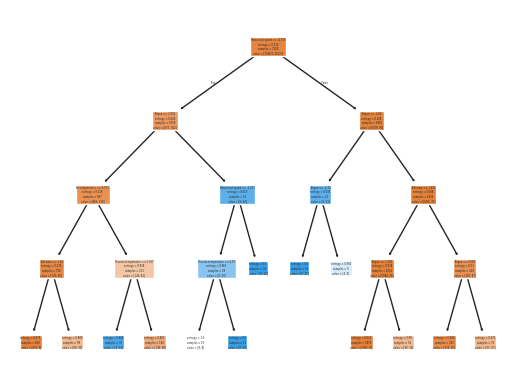

In [ ]:
tree.plot_tree(best_dt, feature_names=X_mf.columns, filled=True)

A interpretabilidade do modelo também se encontra comprometida, com 4 nós de profundidade e 10 nós folhas.

### **5. Global Surrogates**

### 5.1 Modelo caixa-preta e modelo caixa-branca 1:

O modelo de Random Forest treinado com os melhores parâmetros será o modelo caixa-preta. Um modelo global surrogate de árvore de decisão simulará o modelo caixa-preta.


In [ ]:
dt_surrogate = DecisionTreeClassifier()
dt_surrogate.fit(X_test_scaled, y_pred_rf)

DecisionTreeClassifier()

[Text(0.673828125, 0.95, 'Torque <= 2.506\ngini = 0.058\nsamples = 2500\nvalue = [2425, 75]'),
 Text(0.642578125, 0.85, 'Rotational speed <= 5.347\ngini = 0.049\nsamples = 2488\nvalue = [2425, 63]'),
 Text(0.658203125, 0.8999999999999999, 'True  '),
 Text(0.611328125, 0.75, 'Rotational speed <= -0.886\ngini = 0.043\nsamples = 2480\nvalue = [2425, 55]'),
 Text(0.31640625, 0.65, 'Air temperature <= 0.771\ngini = 0.251\nsamples = 333\nvalue = [284.0, 49.0]'),
 Text(0.125, 0.55, 'Tool wear <= 1.476\ngini = 0.084\nsamples = 250\nvalue = [239, 11]'),
 Text(0.0625, 0.45, 'Torque <= 2.341\ngini = 0.009\nsamples = 230\nvalue = [229, 1]'),
 Text(0.03125, 0.35, 'gini = 0.0\nsamples = 224\nvalue = [224, 0]'),
 Text(0.09375, 0.35, 'Rotational speed <= -1.066\ngini = 0.278\nsamples = 6\nvalue = [5, 1]'),
 Text(0.0625, 0.25, 'gini = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(0.125, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.1875, 0.45, 'Torque <= 1.297\ngini = 0.5\nsamples = 20\nvalue =

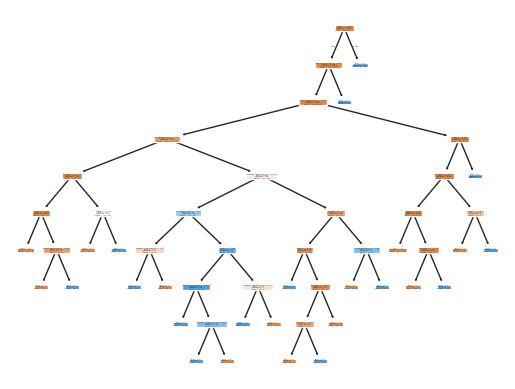

In [ ]:
tree.plot_tree(dt_surrogate, feature_names=X_mf.columns, filled=True)

### 5.2 Modelo caixa-preta e modelo caixa-branca 2

In [ ]:
dt_surrogate2 = DecisionTreeClassifier()
dtr_params = {
    'criterion':['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': randint(2,5),
    'min_samples_split': randint(2,5),
    'min_samples_leaf': randint(2,5),
    'max_features': [None, 'sqrt', 'log2'],
    'random_state': [0, 13, 42],
}

dt_randomized = RandomizedSearchCV(dt_surrogate2,
                                   dtr_params,
                                   n_iter=20,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)
dt_randomized.fit(X_test_scaled, y_pred_rf)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a0cbf190>,
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a0cbf250>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b62a0cbfdc0>,
                                        'random_state': [0, 13, 42],
                                        'splitter': ['best', 'random']},
                   scoring='f1')

In [ ]:
best_params_dt_surrogate = dt_randomized.best_params_
best_model_dt_surrogate = dt_randomized.best_estimator_
best_model_dt_surrogate

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='log2',
                       min_samples_leaf=3, random_state=13)

[Text(0.5, 0.875, 'Torque <= 1.127\nentropy = 0.194\nsamples = 2500\nvalue = [2425, 75]'),
 Text(0.25, 0.625, 'Air temperature <= 0.771\nentropy = 0.081\nsamples = 2187\nvalue = [2165.0, 22.0]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Torque <= -2.65\nentropy = 0.039\nsamples = 1666\nvalue = [1659, 7]'),
 Text(0.0625, 0.125, 'entropy = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(0.1875, 0.125, 'entropy = 0.0\nsamples = 1659\nvalue = [1659, 0]'),
 Text(0.375, 0.375, 'Rotational speed <= -0.886\nentropy = 0.188\nsamples = 521\nvalue = [506, 15]'),
 Text(0.3125, 0.125, 'entropy = 0.989\nsamples = 32\nvalue = [18, 14]'),
 Text(0.4375, 0.125, 'entropy = 0.021\nsamples = 489\nvalue = [488, 1]'),
 Text(0.75, 0.625, 'Tool wear <= 1.492\nentropy = 0.656\nsamples = 313\nvalue = [260, 53]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Torque <= 2.506\nentropy = 0.552\nsamples = 297\nvalue = [259, 38]'),
 Text(0.5625, 0.125, 'entropy = 0.441\nsamples = 285\nvalue = [259, 26]'),
 

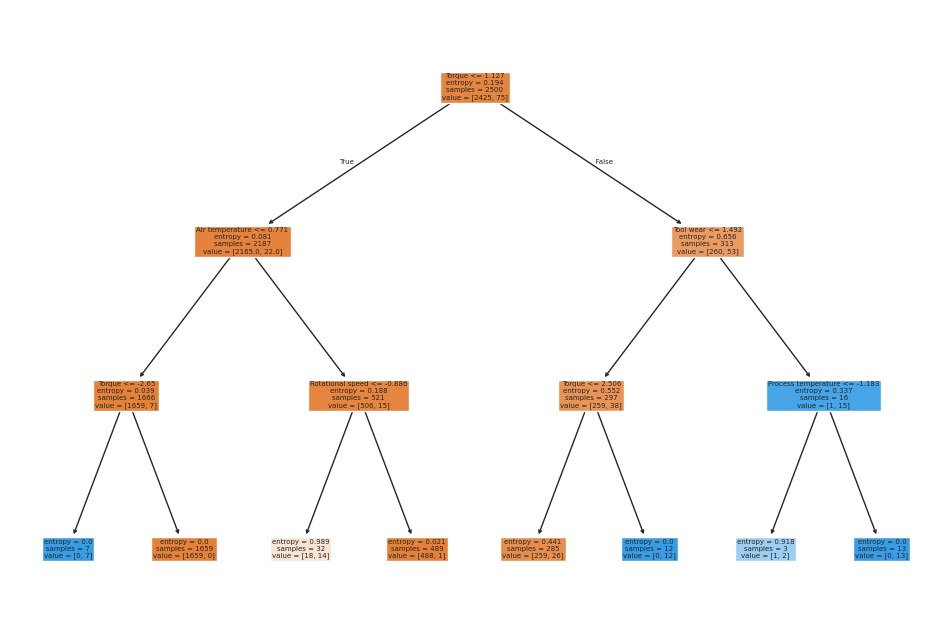

In [ ]:
plt.figure(figsize=(12, 8))
tree.plot_tree(best_model_dt_surrogate, feature_names=X.columns, filled=True)

- O modelo surrogate 1 sem a seleção dos melhores hiperparâmetros trouxe uma árvore com 9 nós de profundidade, perdendo completamente a interpretabilidade, já que é impossível entender como as regras são tomadas.

- Já o modelo surrogate 2, através da seleção dos melhores hiperparâmetros, trás uma árvore com 3 nós de profundidade, mantendo um trade-off de interpretabilidade e aproximação do modelo caixa-preta, mas ainda assim sendo difícil entender como as decisões são tomadas.

### 5.3 Análise $R^{2}$ para os dois modelos Surrogates

In [ ]:
y_pred_dt1_sg = dt_surrogate.predict(X_test_scaled)
y_pred_dt2_sg = best_model_dt_surrogate.predict(X_test_scaled)
y_pred_mean = y_pred_rf.mean()

sse1 = 0
sse2 = 0
for i in range(len(y_pred_rf)):
  sse1 += (y_pred_dt1_sg[i] - y_pred_rf[i])**2
  sse2 += (y_pred_dt2_sg[i] - y_pred_rf[i])**2

sst = 0
for i in range(len(y_pred_rf)):
  sst += (y_pred_rf[i] - y_pred_mean)**2

r_squared_sg1 = 1 - (sse1/sst)
r_squared_sg2 = 1 - (sse2/sst)
print(f'R squared para o modelo surrogate 1: {r_squared_sg1}')
print(f'R squared para o modelo surrogate 2: {r_squared_sg2}')


R squared para o modelo surrogate 1: 1.0
R squared para o modelo surrogate 2: 0.4226804123711547


- Os resultados obtidos deixam claro como foi importante a escolha de hiperparâmetros adequados para o modelo surrogate 2. O modelo Surrogate 1 obteve $R^2$ igual a 1, indicando ser 100% fiel ao comportamento do modelo caixa-preta, porém comprometendo completamente a interpretabilidade de como a árvore tomou as decisões.
- Já o modelo Surrogate 2 obteve $R^2$ próximo de 0.42, indicando uma baixa capacidade de explicar o comportamento do modelo caixa-preta.

###  **6. Permutation Feature Importance (PFI)**

### 6.1 Modelo Random Forest

In [ ]:
result_rf_f1 = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=30, random_state=13, scoring='f1')
forest_importances_f1 = pd.Series(result_rf_f1.importances_mean, index=X_mf.columns)

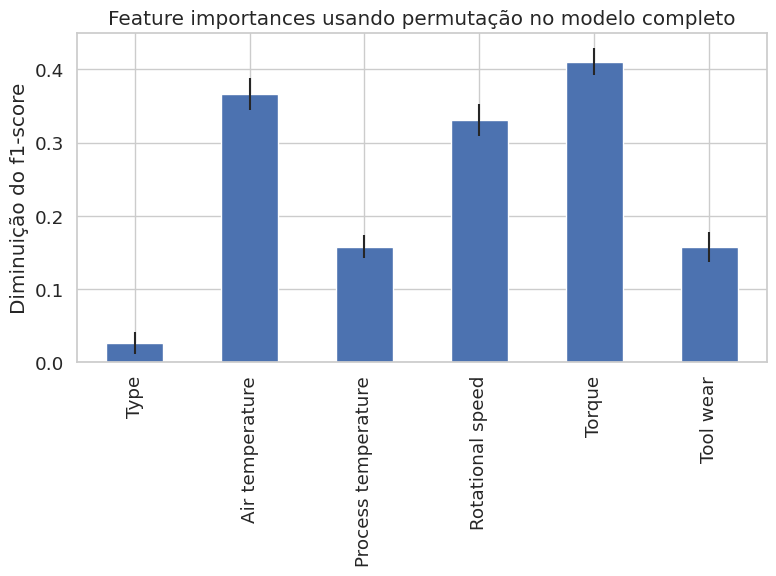

In [ ]:
fig = plt.figure(figsize=(8,6))

forest_importances_f1.plot.bar(yerr=result_rf_f1.importances_std)

plt.title("Feature importances usando permutação no modelo completo")
plt.ylabel("Diminuição do f1-score")
plt.tight_layout()
plt.show()

### 6.1.1 Variáveis que mais influenciam a queda do f1-score

In [ ]:
forest_importances_f1.sort_values(ascending=False)

Torque                 0.410403
Air temperature        0.366440
Rotational speed       0.330791
Process temperature    0.157621
Tool wear              0.156932
Type                   0.026455
dtype: float64

Os resultados apresentados mostram que para a queda da métrica f1-score, as seguintes variáveis são as mais importantes na predição de falhas em máquinas:
- Torque
- Air temperature
- Rotational speed
- process temperature
- Tool wear

A variável Type pode ser removida do modelo, pois não tem influência na predição do classificador.

In [ ]:
result_rf_auc = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=30, random_state=13, scoring='roc_auc')
forest_importances_auc = pd.Series(result_rf_auc.importances_mean, index=X_mf.columns)

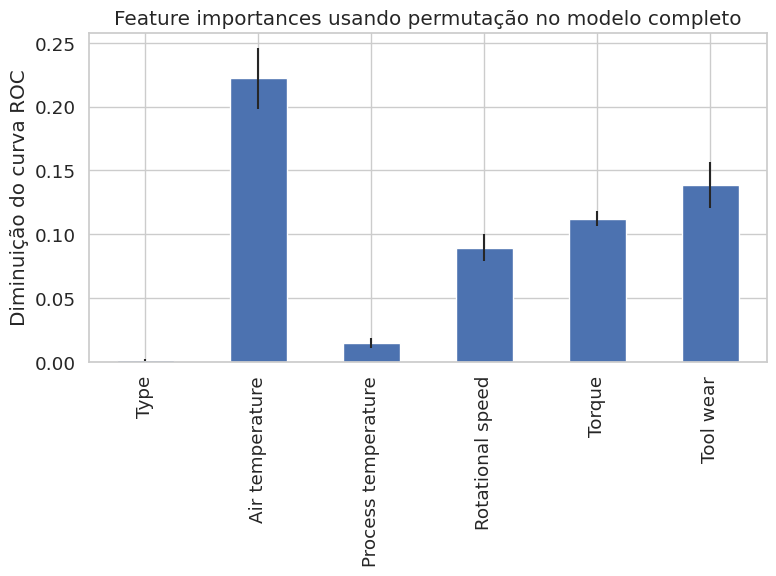

In [ ]:
fig = plt.figure(figsize=(8,6))

forest_importances_auc.plot.bar(yerr=result_rf_auc.importances_std)

plt.title("Feature importances usando permutação no modelo completo")
plt.ylabel("Diminuição do curva ROC")
plt.tight_layout()
plt.show()

### 6.1.2 Variáveis que mais influenciam a queda da curva ROC

In [ ]:
forest_importances_auc.sort_values(ascending=False)

Air temperature        0.222103
Tool wear              0.138625
Torque                 0.112377
Rotational speed       0.089506
Process temperature    0.014743
Type                   0.001619
dtype: float64

O resultados apresentados mostram que para a queda da métrica da curva ROC, as seguintes variáveis são as mais importantes na predição de falhas em máquinas:
- Air temperature
- Tool wear
- Torque
- Rotational speed
- process temperature

A variável Type pode ser removida do modelo, pois não tem influência na predição do classificador.

### 6.2 PFI Classe minoritária (Falhou)

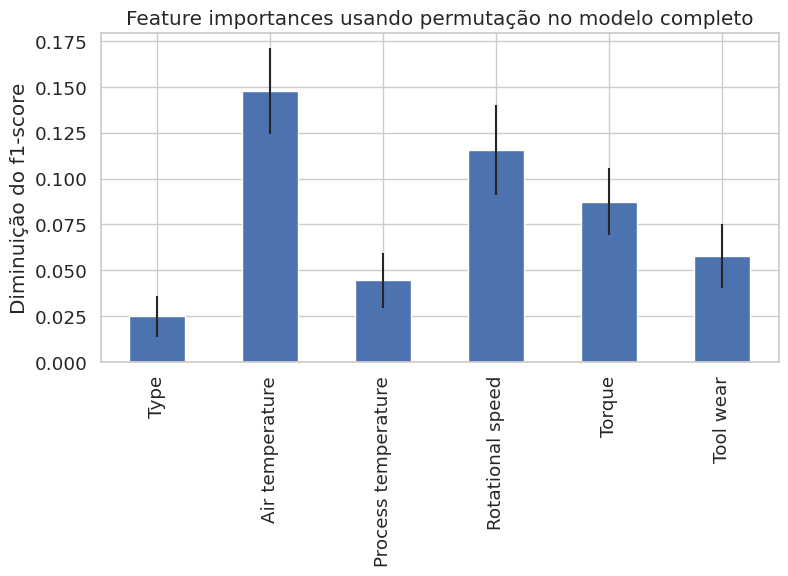

In [ ]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test_minor = df_test[df_test['Machine failure'] == 1]
X_test_minor = df_test_minor.drop(columns="Machine failure")
y_test_minor = df_test_minor['Machine failure']

X_test_minor_scaled = scaler.transform(X_test_minor)

result_rf_f1_minor = permutation_importance(best_rf, X_test_minor_scaled, y_test_minor, n_repeats=30, random_state=13, scoring='f1')
forest_importances_f1_minor = pd.Series(result_rf_f1_minor.importances_mean, index=X_test_minor.columns)

fig = plt.figure(figsize=(8,6))

forest_importances_f1_minor.plot.bar(yerr=result_rf_f1_minor.importances_std)

plt.title("Feature importances usando permutação no modelo completo")
plt.ylabel("Diminuição do f1-score")
plt.tight_layout()
plt.show()

### 6.3 Classe Majoritária (Não falhou)

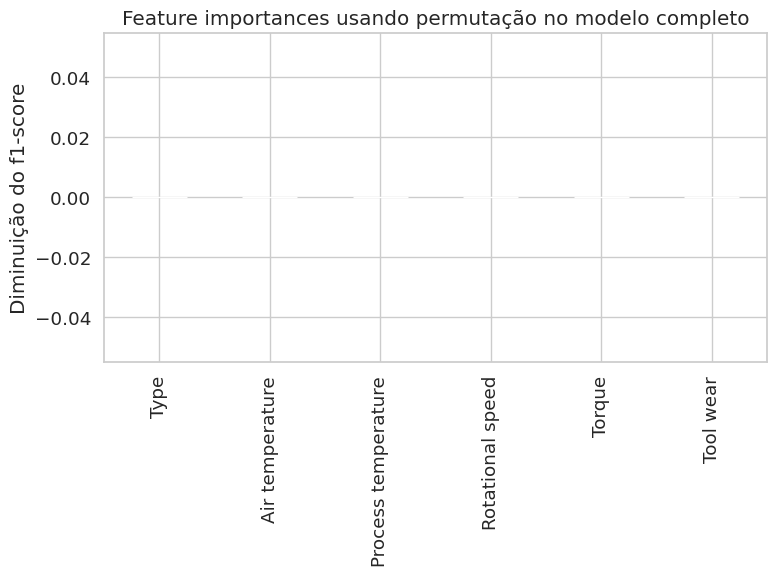

In [ ]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test_major = df_test[df_test['Machine failure'] == 0]
X_test_major = df_test_major.drop(columns="Machine failure")
y_test_major = df_test_major['Machine failure']

X_test_major_scaled = scaler.transform(X_test_major)

result_rf_f1_major = permutation_importance(best_rf, X_test_major_scaled, y_test_major, n_repeats=30, random_state=13, scoring='f1')
forest_importances_f1_major = pd.Series(result_rf_f1_major.importances_mean, index=X_test_major.columns)

fig = plt.figure(figsize=(8,6))

forest_importances_f1_major.plot.bar(yerr=result_rf_f1_major.importances_std)

plt.title("Feature importances usando permutação no modelo completo")
plt.ylabel("Diminuição do f1-score")
plt.tight_layout()
plt.show()

- Aplicando PFI, fica claro que o desbalanceamento de classes tem uma influência grande na capacidade do modelo de Random Forest identificar a importância das variáveis da classe majoritária. Com PFI igual a zero, isso indica que, ao realizar as permutações nas variáveis, o desempenho do modelo para prever a classe majoritária (não falha) não foi afetado. Isso sugere que o modelo pode estar tão confiante na predição dessa classe que as variáveis não influenciam significativamente o resultado.

- Já para a classe minoritária, PFI maior que zero para todas as variáveis sugere que o classificador está realmente usando as variáveis para identificar as falhas, o que faz sentido, já que precisa de mais informações para predição da classe minoritária.

### **7. Feature Selection**

A variável *Type* será removida conforme análise do PFI, e o modelo de Random Forest será novamente treinado com os dados escalonados, aplicação do RandomizedSearchCV e StratifiedKfold.

In [ ]:
df_mf = df_mf.drop(columns='Type')
df_mf.head()

Air temperature  Process temperature  Rotational speed  Torque  Tool wear  \
0            298.1                308.6              1551    42.8          0   
1            298.2                308.7              1408    46.3          3   
2            298.1                308.5              1498    49.4          5   
3            298.2                308.6              1433    39.5          7   
4            298.2                308.7              1408    40.0          9   

   Machine failure  
0                0  
1                0  
2                0  
3                0  
4                0

In [ ]:
X_mf_fs = df_mf.drop('Machine failure', axis=1)
y_mf_fs = df_mf['Machine failure']

X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_mf_fs, y_mf_fs, stratify=y_mf_fs, random_state=42)

scaler = StandardScaler()
X_train_scaled_fs = scaler.fit_transform(X_train_fs)
X_test_scaled_fs = scaler.transform(X_test_fs)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_fs = RandomForestClassifier()

rf_params_fs = {
    'n_estimators': randint(50,200),
    'criterion':['gini', 'entropy'],
    'max_depth': randint(2,10),
    'min_samples_split': randint(2,10),
    'min_samples_leaf': randint(2,10),
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'random_state': [0, 13, 42],
}

rf_randomized_fs = RandomizedSearchCV(rf_fs,
                                   rf_params_fs,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)

rf_randomized_fs.fit(X_train_scaled_fs, y_train_fs)

best_params_rf_fs = rf_randomized_fs.best_params_
best_model_rf_fs = rf_randomized_fs.best_estimator_

print(f'Melhores hiperparâmetros: {best_params_rf_fs}')
print(f'Melhor modelo: {best_model_rf_fs}')

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 158, 'n_jobs': -1, 'random_state': 13}
Melhor modelo: RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=158, n_jobs=-1, random_state=13)


In [ ]:
best_rf_fs = RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=158, n_jobs=-1, random_state=13)

best_rf_fs.fit(X_train_scaled_fs, y_train_fs)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       min_samples_leaf=4, min_samples_split=4,
                       n_estimators=158, n_jobs=-1, random_state=13)

In [ ]:
y_pred_rf_fs = best_rf_fs.predict(X_test_scaled_fs)
print(classification_report(y_test_fs, y_pred_rf_fs))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2415
           1       0.85      0.73      0.78        85

    accuracy                           0.99      2500
   macro avg       0.92      0.86      0.89      2500
weighted avg       0.99      0.99      0.99      2500



In [ ]:
mcc_fs = matthews_corrcoef(y_test_fs, y_pred_rf_fs)
print(f'MCC: {mcc_fs}')

MCC: 0.7802324147452148


### 7.1 Análise dos resultados

A remoção da variável *Type* não teve grande impacto ao se comparar com os resultados anteriores obtidos para o modelo de Random Forest, portanto, o modelo anterior obtido continua como o melhor obtido referente ao modelo de Random Forest.

### **8. LIME**

### 8.1 Definindo modelo para o Lime

Como o modelo não é afetado pela escala, para análises do LIME serão consideradas as variáveis com seus valores padrões, e os melhores hiperparâmetros serão determinados para este caso.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mf, y_mf, stratify=y_mf, random_state=42)

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rf_lime = RandomForestClassifier()

rf_params_lime = {
    'n_estimators': randint(50,200),
    'criterion':['gini', 'entropy'],
    'max_depth': randint(2,10),
    'min_samples_split': randint(2,10),
    'min_samples_leaf': randint(2,10),
    'max_features': ['sqrt', 'log2', None],
    'n_jobs': [-1],
    'random_state': [0, 13, 42],
}

rf_randomized_lime = RandomizedSearchCV(rf_lime,
                                   rf_params_lime,
                                   n_iter=10,
                                   n_jobs=-1,
                                   scoring='f1',
                                   cv=skf)

rf_randomized_lime.fit(X_train, y_train)

best_params_rf_lime = rf_randomized_lime.best_params_
best_model_rf_lime = rf_randomized_lime.best_estimator_

print(f'Melhores hiperparâmetros: {best_params_rf_lime}')
print(f'Melhor modelo: {best_model_rf_lime}')

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 116, 'n_jobs': -1, 'random_state': 13}
Melhor modelo: RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=116, n_jobs=-1,
                       random_state=13)


In [ ]:
best_rf_lime = RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=116, n_jobs=-1,
                       random_state=13)

### 8.2 Criando um explicador utilizando LIME nos dados de treinamento

In [ ]:
feature_names = list(X_train.columns)

In [ ]:
best_rf_lime.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=8, max_features=None, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=116, n_jobs=-1,
                       random_state=13)

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   feature_names=feature_names,
                                                   class_names=[0, 1], mode='classification')

### 8.3 Selecionando Instância 1

In [ ]:
i = np.random.randint(0, X_test.shape[0])
i

1837

In [ ]:
exp = explainer.explain_instance(X_test.iloc[i], best_rf_lime.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

### 8.3.1 Análise instância 1

Para a instância 1 selecionada aleatoriamente, a classe majoritária (Não falhou) tem 0.96 de probabilidade, sendo a mais provável. As variáveis Tool wear, Torque, Air temperature, Rotational speed, Process temperature são as mais importantes para esta instância em específico na determinação da probabilidades preditas. Os intervalos de valores pequenos para cada variável indicam estabilidade das explicações.

### 8.4 Selecionando Instância 2

In [ ]:
j = np.random.randint(0, X_test.shape[0])
j

168

In [ ]:
exp = explainer.explain_instance(X_test.iloc[j], best_rf_lime.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

### 8.4.1 Análise Instância 2

Para a instância 2 selecionada aleatoriamente, a classe majoritária (Não falhou) tem 0.85 de probabilidade, sendo a mais provável. As variáveis Air temperature, Rotational speed, Torque, Tool wear, Process temperature são as mais importantes para esta instância em específico na determinação da probabilidades preditas. Os intervalos de valores pequenos para cada variável indicam estabilidade das explicações.

### 8.5 Selecionando Instância 3

In [ ]:
z = np.random.randint(0, X_test.shape[0])
z

821

In [ ]:
exp = explainer.explain_instance(X_test.iloc[z], best_rf_lime.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

### 8.5.1 Análise Instância 3

Para a instância 3 selecionada aleatoriamente, a classe majoritária teve probabilidade 1, e a classe minoritária 0, resultado esperado devido ao desbalanceio das classes, de modo que, os valores e intervalos de valores para cada variável é semelhante aos das instâncias 1 e 2, indicando que sim, a classe majoritária domina a predição do classificador, sendo difícil identificar quais valores das variáveis forneceriam uma predição alta para a classe minoritária

### 8.6 Selecionando Instância 4

In [ ]:
w = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.iloc[w], best_rf_lime.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook()

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

### 8.6.1 Análise Instância 4

A instância 4 conseguiu recuperar uma probabilidade de 0.82 para a classe minoritária, sendo portanto a mais provável. As variáveis mais importantes e seus respectivos valores na ordem são:
1. Air temperatures - 301.80 [K]
2. Rotational speed - 1334.0 [rpm]
3. Torque 61.00 [Nm]
4. Tool wear - 182.00 [min]
5. Process temperature - 309.90 [K]



### **9. Partial Dependence Plots - *$PDP_{S}$***

O modelo de Random Forest usado no LIME será usado também aqui no PDP.

In [ ]:
X_test.head()

Air temperature  Process temperature  Rotational speed  Torque  \
1390            298.9                310.2              1409    54.8   
2925            300.7                309.6              1388    51.1   
2488            298.9                308.7              1356    50.7   
5844            301.4                311.1              1462    37.1   
7978            301.2                312.4              1480    53.5   

      Tool wear  
1390        140  
2925        160  
2488        185  
5844         41  
7978         97

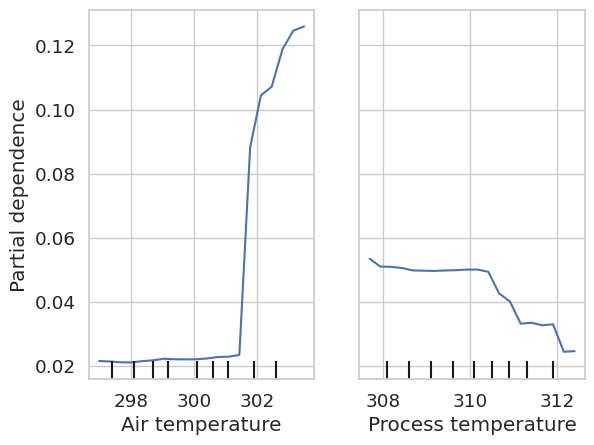

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but RandomForestClassifier was fitted without feature names")
disp1 = PartialDependenceDisplay.from_estimator(best_rf_lime, X_test, [0, 1],grid_resolution=20)

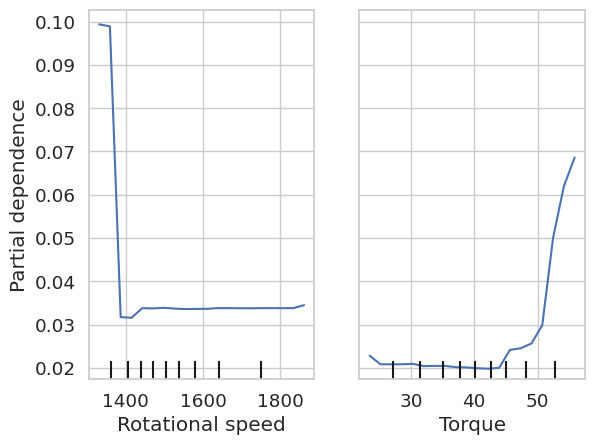

In [ ]:
disp2 = PartialDependenceDisplay.from_estimator(best_rf_lime, X_test, [2, 3],grid_resolution=20)

### 9.1 Análise PDPs obtidos

Considerando que a classe majoritária (Não falhou) domina a predição do modelo, pois se trata de classes desbalanceadas, as seguintes análises podem ser feitas para as variáveis acima:
1. Air temperature: A partir da temperatura 301 K, a probabilidade de predição aumentou exponencialmente de pouco mais de 1% para 13%.

2. Process temperature: Houve uma queda gradativa da temperatura de processo a partir de 310 K, com a probabilidade de predição caindo e se mantendo estável a partir de 312 K.

3. Rotational speed: A probabilidade de predição caiu vertiginosamente de 10% para próximo de 3% quando a velocidade de rotação foi aumentando a partir de 1400 e se mantendo com PDP estável em torno de 3% em diante.

4. Torque: A partir de um valor de torque em torno de 45, a predição de probabilidade cresceu de forma exponencial de 2% para 7%.

Os resultados apresentados deixam claro que os valores das variáveis têm uma influência direta na predição da classe majoritária, apesar do desbalanceio de classes.